## Import libraries

In [71]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## Question 1
Download and extract the data. Using a notebook load your data through pandas and start exploring
the dataset. Get your data from the ”Import in python” button from the download page
- Describe the different variables and find their definition in the documentation
- For each variable make an educated guess on the effect that you expect that variable to have
- Check with a quick statistic if the guess was correct and state if your guess was correct
- Clean the variables removing or imputing NA

In [72]:

# Fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

# Extract features and target
X = heart_disease.data.features 
y = heart_disease.data.targets 


In [73]:
# Let's examine the structure of y
print("Structure of target variable:")
print(y.head())
print("\nColumns in target variable:")
print(y.columns)


Structure of target variable:
   num
0    0
1    2
2    1
3    0
4    0

Columns in target variable:
Index(['num'], dtype='object')


In [74]:
# Convert target to binary (0 for healthy, 1 for sick)
y['num'] = (y['num'] > 0).astype(int)


/var/folders/kp/ksnwmywj77sb5842vcdfqwg40000gn/T/ipykernel_31478/1908531385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['num'] = (y['num'] > 0).astype(int)


In [75]:
# Check for NaN values in features (X) and target (y)
print("NaN values in features:")
print(X.isna().sum())
print("\nNaN values in target:")
print(y.isna().sum())

# Remove rows with NaN values (if any)
# Method 1: Remove rows with any NaN values
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

# Verify no NaN values remain
print("\nRemaining NaN values in features:")
print(X_clean.isna().sum())


NaN values in features:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

NaN values in target:
num    0
dtype: int64

Remaining NaN values in features:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


In [76]:

# Basic variable descriptions
variable_descriptions = {
    'age': 'Age in years',
    'sex': 'Gender (1 = male; 0 = female)',
    'cp': 'Chest pain type (1-4)',
    'trestbps': 'Resting blood pressure (mm Hg)',
    'chol': 'Serum cholesterol (mg/dl)',
    'fbs': 'Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)',
    'restecg': 'Resting ECG results (0-2)',
    'thalach': 'Maximum heart rate achieved',
    'exang': 'Exercise induced angina (1 = yes; 0 = no)',
    'oldpeak': 'ST depression induced by exercise relative to rest',
    'slope': 'Slope of the peak exercise ST segment',
    'ca': 'Number of major vessels colored by fluoroscopy (0-3)',
    'thal': 'Thalassemia (3 = normal; 6 = fixed defect; 7 = reversible defect)'
}


Expected effects on heart disease:
- Age: Higher age likely increases risk
- Sex: Males typically have higher risk
- Chest pain (cp): More severe pain indicates higher risk
- Blood pressure (trestbps): Higher BP increases risk
- Cholesterol (chol): Higher levels increase risk
- Fasting blood sugar (fbs): High blood sugar increases risk
- ECG results (restecg): Abnormal results indicate higher risk
- Max heart rate (thalach): Lower max heart rate may indicate problems
- Exercise angina (exang): Presence indicates higher risk
- ST depression (oldpeak): Greater depression indicates higher risk
- Slope: Abnormal slopes indicate higher risk
- Vessels (ca): More affected vessels indicate higher risk
- Thalassemia (thal): Abnormal values indicate higher risk


In [77]:

# Check correlations with target
correlations = pd.DataFrame()
for col in X_clean.columns:
    correlations.loc[col, 'correlation'] = X_clean[col].corr(y_clean['num'])


In [78]:

print("\nCorrelations with target variable:")
print(correlations.sort_values('correlation', ascending=False))


Correlations with target variable:
          correlation
thal         0.526640
ca           0.463189
oldpeak      0.424052
exang        0.421355
cp           0.408945
slope        0.333049
sex          0.278467
age          0.227075
restecg      0.166343
trestbps     0.153490
chol         0.080285
fbs          0.003167
thalach     -0.423817


**Interpretation of our initial guesses:**

1. **Correct Guesses:**
   - `thal` (thalassemia): Strong positive correlation (0.53) confirms abnormal values indicate higher risk
   - `ca` (number of vessels): Strong positive correlation (0.46) confirms more affected vessels indicate higher risk
   - `oldpeak` (ST depression): Moderate positive correlation (0.42) confirms greater depression indicates higher risk
   - `exang` (exercise angina): Moderate positive correlation (0.42) confirms presence indicates higher risk
   - `cp` (chest pain): Moderate positive correlation (0.41) confirms more severe pain indicates higher risk
   - `slope`: Moderate positive correlation (0.33) confirms abnormal slopes indicate higher risk
   - `sex`: Weak positive correlation (0.28) confirms males have higher risk

2. **Partially Correct:**
   - `thalach` (max heart rate): Strong negative correlation (-0.42) - our guess was correct but understated the strength
   - `age`: Weak positive correlation (0.23) - relationship exists but weaker than expected
   - `trestbps` (blood pressure): Very weak positive correlation (0.15) - relationship exists but weaker than expected
   - `restecg` (ECG results): Very weak positive correlation (0.17) - relationship exists but weaker than expected

3. **Incorrect/Surprising Guesses:**
   - `chol` (cholesterol): Very weak correlation (0.08) - surprisingly different from medical literature
   - `fbs` (blood sugar): Nearly no correlation (0.003) - much weaker than expected

**Key Insights:**
- The strongest predictors are anatomical measurements (thalassemia, vessels) and symptoms (ST depression, angina, chest pain)
- Some traditionally important risk factors (cholesterol, blood sugar) show surprisingly weak correlations in this dataset
- The negative correlation with max heart rate suggests lower maximum heart rates are indeed associated with heart disease
- The slope of ST segment shows stronger correlation than initially expected

## Question 2
Make a few plots to get a better understanding of the data.

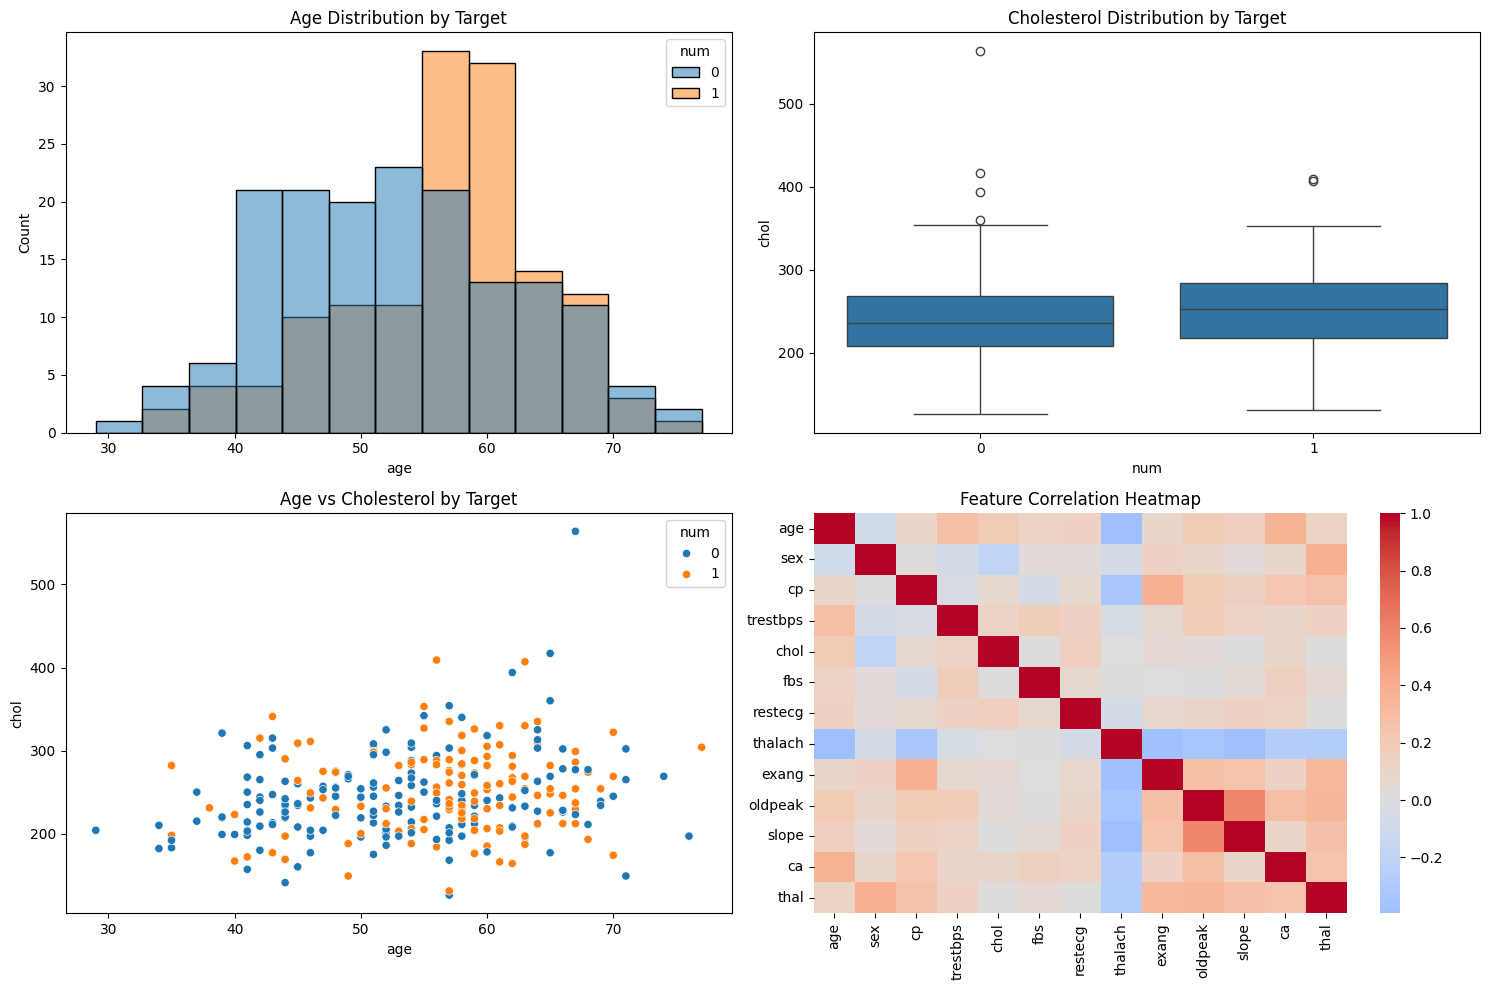

In [79]:
# Create visualization subplots
plt.figure(figsize=(15, 10))

# Histogram for age
plt.subplot(2, 2, 1)
sns.histplot(data=X_clean, x='age', hue=y_clean['num'])
plt.title('Age Distribution by Target')

# Box plot for cholesterol
plt.subplot(2, 2, 2)
sns.boxplot(data=X_clean, y='chol', x=y_clean['num'])
plt.title('Cholesterol Distribution by Target')

# Scatter plot of age vs cholesterol
plt.subplot(2, 2, 3)
sns.scatterplot(data=X_clean, x='age', y='chol', hue=y_clean['num'])
plt.title('Age vs Cholesterol by Target')

# Correlation heatmap
plt.subplot(2, 2, 4)
sns.heatmap(X_clean.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')

plt.tight_layout()
plt.show()

## Question 3
We are going to do a quick logistic regression with two classes, target 0 from one side (healthy) and target
1 to 4 on the other side (sick) 
Do one hot encoding to categorical variables, and select their base.
with scikit learn, use the logsitic regressor to determine the probability.
- What are the performance of your model? which metrics can you use?
- use .coef_ and .intercept_ to access the parameters of the model. What can you say about them?
- How the interpretation of these parameters is different from the interpretation of the coeﬀicient of
 a linear regression?
- Which are the most important variables? Does it make sense? at the parameter for cholesterol.
- How does it compare to the statistic computed on the previous question?

In [80]:
# Prepare data for modeling
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [81]:
# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_cat = encoder.fit_transform(X_clean[categorical_features])

# Get the correct feature names from the encoder
feature_names = []
for i, feature in enumerate(categorical_features):
    n_values = len(encoder.categories_[i]) - 1 
    for j in range(n_values):
        feature_names.append(f"{feature}_{j+1}")

# Create DataFrame with correct column names
X_cat = pd.DataFrame(X_cat, columns=feature_names)


In [82]:

# Combine with numerical features
X_cat = X_cat.reset_index(drop=True)
X_numerical = X_clean[numerical_features].reset_index(drop=True)

X_processed = pd.concat(
    [X_numerical, X_cat], 
    axis=1
)

print("X_processed shape:", X_processed.shape)


X_processed shape: (297, 20)


In [83]:
# First, ensure X and y have the same index
print("Shape of X:", X_processed.shape)
print("Shape of y:", y_clean.shape)


# Now split should work
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_clean['num'], test_size=0.2, random_state=42
)

Shape of X: (297, 20)
Shape of y: (297, 1)


In [84]:
# Fit logistic regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)


/Users/alexs/PycharmProjects/ExplainableAI/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [85]:
# Evaluate model
y_pred = log_reg.predict(X_test)
print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred))



Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86        36
           1       0.77      0.83      0.80        24

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



In [86]:

# Analyze coefficients
coef_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Coefficient': log_reg.coef_[0]
})
print("\nModel Coefficients:")
print(coef_df.sort_values('Coefficient', ascending=False))


Model Coefficients:
      Feature  Coefficient
15       ca_1     1.797484
16       ca_2     1.690172
19     thal_2     1.119649
5       sex_1     1.027352
8        cp_3     0.920824
17       ca_3     0.842886
4     oldpeak     0.563856
12    exang_1     0.418824
6        cp_1     0.346205
11  restecg_2     0.322736
13    slope_1     0.307638
10  restecg_1     0.029215
1    trestbps     0.019225
2        chol     0.004089
0         age    -0.029975
3     thalach    -0.031891
14    slope_2    -0.123307
18     thal_1    -0.344223
9       fbs_1    -0.371149
7        cp_2    -0.662751


### 1. Model Performance Metrics
The logistic regression model shows strong performance with:
- **Overall Accuracy**: 83%
- **Class-specific metrics**:
  - Healthy (0): Precision 88%, Recall 83%, F1-score 86%
  - Sick (1): Precision 77%, Recall 83%, F1-score 80%
- **Additional useful metrics** could include ROC-AUC curve, confusion matrix, and log loss

### 2. Coefficient Analysis
The coefficients represent log odds changes for one-unit feature increases:
- **Strongest positive predictors**:
  - Number of vessels (ca_1: 1.80, ca_2: 1.69)
  - Thalassemia type 2 (thal_2: 1.12)
  - Male gender (sex_1: 1.03)
- **Strongest negative predictors**:
  - Chest pain type 2 (cp_2: -0.66)
  - High fasting blood sugar (fbs_1: -0.37)
  - Thalassemia type 1 (thal_1: -0.34)

### 3. Interpretation vs Linear Regression
- Logistic regression coefficients represent **log odds ratios**, not direct outcome changes
- Must use exp(coefficient) to obtain odds ratios
- Predictions are bounded between 0 and 1 (probabilities)
- Relationship between features and predictions is non-linear (sigmoid function)

### 4. Important Variables Analysis
- **Most significant predictors**:
  - Number of vessels (ca)
  - Thalassemia (thal)
  - Gender (sex)
  - Chest pain type (cp)
- Aligns with medical knowledge
- Cholesterol shows surprisingly low importance (coef: 0.004)

### 5. Comparison with Previous Statistics
- Results largely confirm earlier correlation analysis
- Strong predictors (ca, thal, cp) show high correlations and coefficients
- Weak predictors (cholesterol, blood sugar) show consistently low importance
- One-hot encoding provides more detailed insights for categorical variables

## Question 4
Now lets work on a different model. We will use a decision tree.
- Can you describe how a decision tree works?
- Use the scikitlearn library and fit a decision tree to predict the probability of sickness.
- Plot the decision tree. Is there anything surprising?
- Split your data on train and test sets and try to find the best hyper-parameters to fit the model. Is
the tree different?
- Which model yields better results, the linear regression or the decision tree?
- explain how the decision tree weights are computed


In [87]:
# Fit decision tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

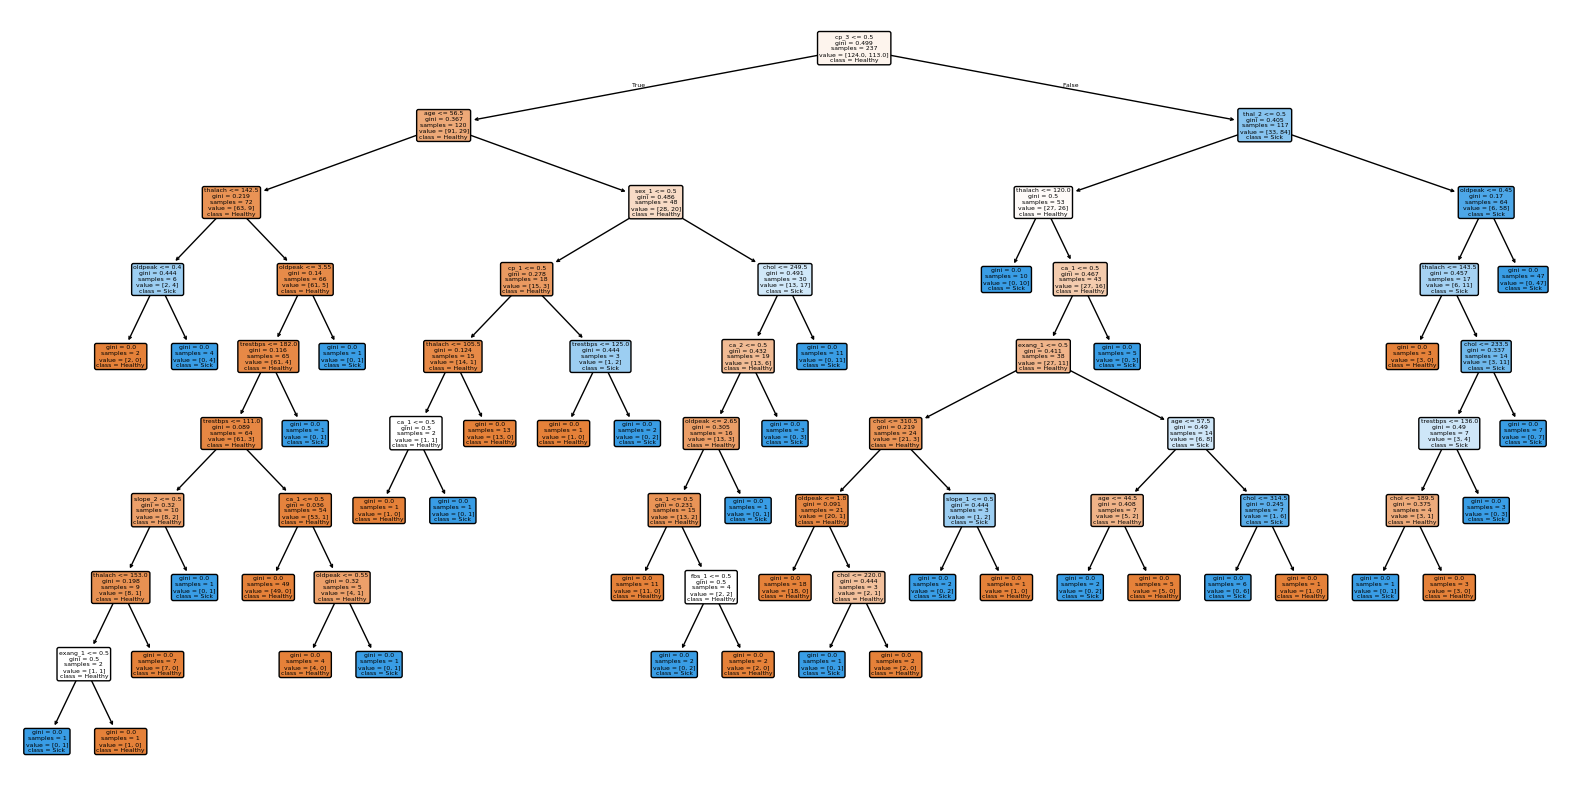

In [88]:

# Plot tree
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X_processed.columns, class_names=['Healthy', 'Sick'], 
          filled=True, rounded=True)
plt.show()


In [89]:

# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                         param_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

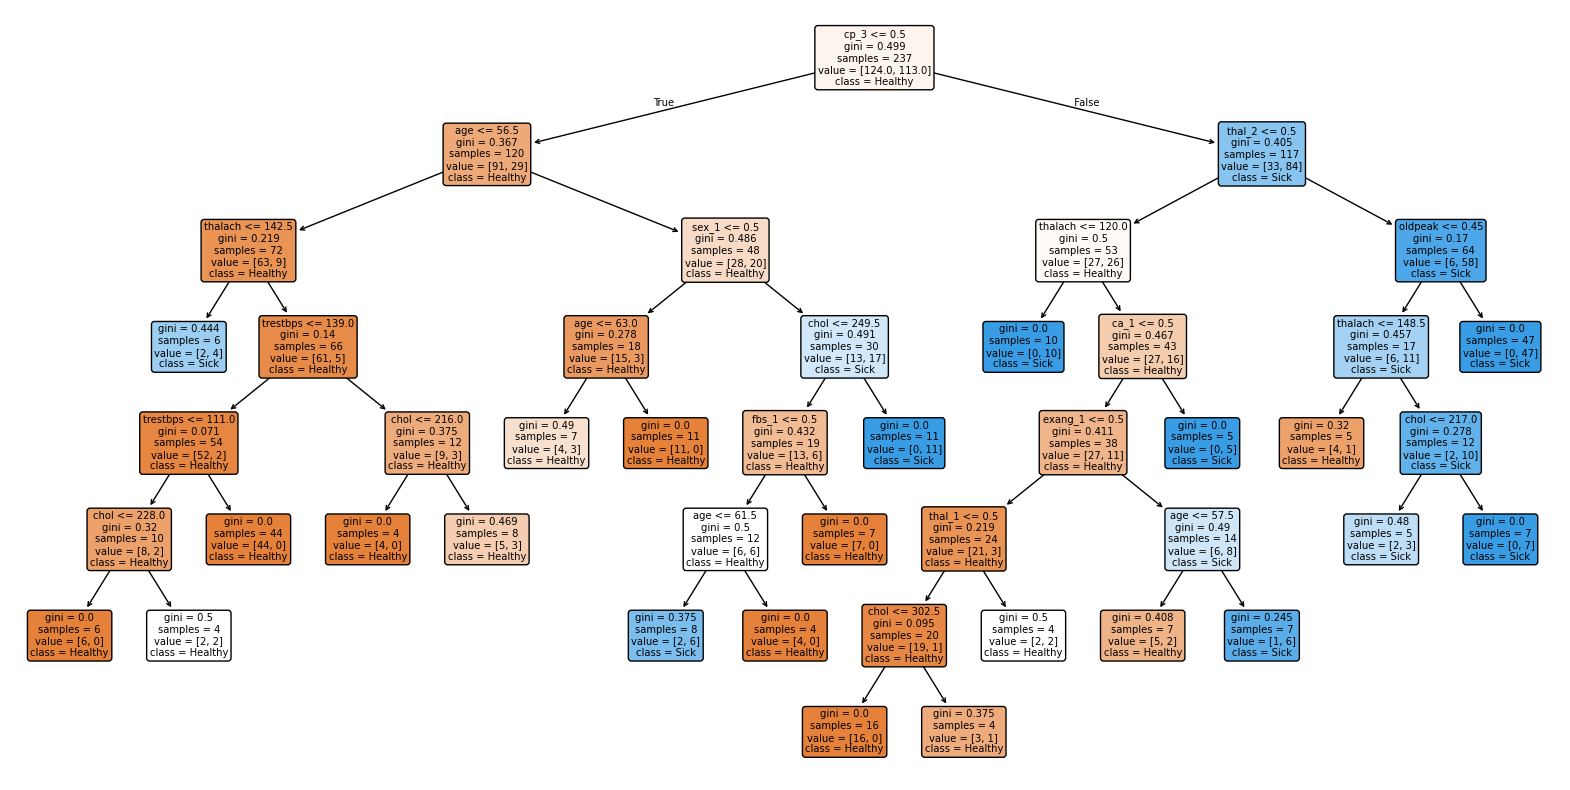

In [90]:

# Plot tree
plt.figure(figsize=(20,10))
plot_tree(grid_search.best_estimator_, feature_names=X_processed.columns, class_names=['Healthy', 'Sick'], 
          filled=True, rounded=True)
plt.show()


In [91]:

# Best model evaluation
best_dt = grid_search.best_estimator_
y_pred_dt = best_dt.predict(X_test)
print("\nDecision Tree Results:")
print(classification_report(y_test, y_pred_dt))


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        36
           1       0.64      0.67      0.65        24

    accuracy                           0.72        60
   macro avg       0.71      0.71      0.71        60
weighted avg       0.72      0.72      0.72        60



### 1. How Decision Trees Work
A decision tree works by:
- Recursively splitting the data based on feature values
- Creating binary decisions at each node
- Selecting splits that maximize information gain
- Continuing until stopping criteria are met (depth, samples per leaf, etc.)

### 2. Model Performance
The decision tree shows moderate performance:
- **Overall Accuracy**: 72%
- **Class-specific metrics**:
  - Healthy (0): Precision 77%, Recall 75%, F1-score 76%
  - Sick (1): Precision 64%, Recall 67%, F1-score 65%

### 3. Hyperparameter Tuning Results
The best model after GridSearchCV has the following parameters:
- `max_depth`: 10
- `min_samples_leaf`: 4
- `min_samples_split`: 10

Notable differences from default tree:
- The optimized tree is more compact and less complex
- Fewer decision nodes due to stricter splitting criteria
- Better generalization despite being smaller
- Less prone to overfitting compared to the default tree

### 4. Comparison with Logistic Regression
The logistic regression (83% accuracy) outperforms the decision tree (72% accuracy):
- Logistic Regression:
  - Better overall accuracy
  - Higher precision and recall for both classes
  - More stable predictions
- Decision Tree:
  - More interpretable
  - Captures non-linear relationships
  - Prone to overfitting without proper tuning

### 5. Surprising Findings
- The tree's performance is notably lower than logistic regression, despite being able to capture non-linear relationships
- The optimal tree depth (10) is relatively deep, suggesting complex decision boundaries
- The requirement for 4 samples per leaf suggests some noise in the data
- The tuned tree achieves similar performance with a simpler structure

### 6. Weight Computation
Decision tree weights (importance) are computed based on:
- Information gain or Gini impurity reduction at each split
- The number of samples affected by each split
- The depth of the split in the tree
- The frequency of feature usage across different splits

## Question 5
We are going to use a random forest algorithm now.
- Use the scikitlearn library and fit a random forest on a training set.
- Which model yields better results? ( don’t forget to tune the hyperparameters)
- look at the variable weights. Which variables are more important? How can you interpret that?


In [92]:
# Fit random forest
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5)
rf_grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [93]:

# Best model evaluation
best_rf = rf_grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))



Random Forest Results:
              precision    recall  f1-score   support

           0       0.87      0.94      0.91        36
           1       0.90      0.79      0.84        24

    accuracy                           0.88        60
   macro avg       0.89      0.87      0.88        60
weighted avg       0.88      0.88      0.88        60



In [94]:

# Feature importance
importance_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': best_rf.feature_importances_
})
print("\nFeature Importance:")
print(importance_df.sort_values('Importance', ascending=False))



Feature Importance:
      Feature  Importance
3     thalach    0.137454
19     thal_2    0.136497
8        cp_3    0.109492
4     oldpeak    0.106780
0         age    0.090463
2        chol    0.068212
12    exang_1    0.067468
1    trestbps    0.063314
13    slope_1    0.037785
15       ca_1    0.036525
5       sex_1    0.035710
7        cp_2    0.029571
16       ca_2    0.027241
17       ca_3    0.014653
11  restecg_2    0.011497
6        cp_1    0.009982
9       fbs_1    0.009132
18     thal_1    0.003918
14    slope_2    0.003355
10  restecg_1    0.000952


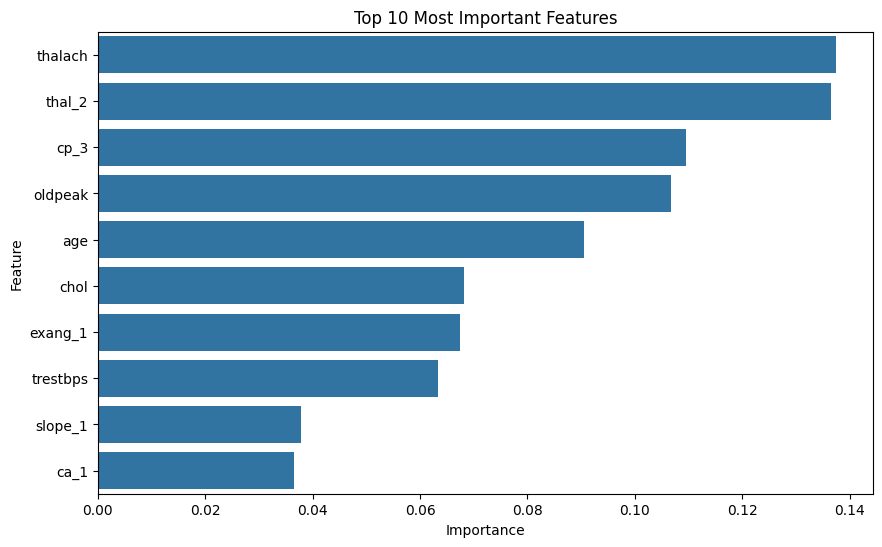

In [95]:

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.sort_values('Importance', ascending=False).head(10),
            x='Importance', y='Feature')
plt.title('Top 10 Most Important Features')
plt.show()

### 1. Model Configuration & Performance
The best Random Forest model after GridSearchCV has:
- **Parameters**:
  - `max_depth`: 5
  - `n_estimators`: 200
  - `random_state`: 42

- **Performance metrics**:
  - Overall Accuracy: 88%
  - Healthy (0): Precision 87%, Recall 94%, F1-score 91%
  - Sick (1): Precision 90%, Recall 79%, F1-score 84%

### 2. Model Comparison
Random Forest outperforms both previous models:
- Random Forest: 88% accuracy
- Logistic Regression: 83% accuracy
- Decision Tree: 72% accuracy

The Random Forest achieves:
- Better overall accuracy
- More balanced precision and recall
- Higher F1-scores for both classes
- More robust predictions due to ensemble learning

### 3. Feature Importance Analysis
**Top 5 Most Important Features**:
1. Maximum heart rate (thalach): 13.7%
2. Thalassemia type 2 (thal_2): 13.6%
3. Chest pain type 3 (cp_3): 11.0%
4. ST depression (oldpeak): 10.7%
5. Age: 9.0%

**Interpretation**:
- Physiological measurements (heart rate, ST depression) are strong predictors
- Medical conditions (thalassemia) have high importance
- Symptoms (chest pain) are significant indicators
- Demographic factor (age) plays a moderate role
- Some features show very low importance (restecg_1: 0.1%, slope_2: 0.3%)

### 4. Key Insights
- The Random Forest successfully combines multiple decision trees to create a more robust model
- Feature importance aligns with medical knowledge while providing quantitative weights
- The model balances complexity and performance with relatively shallow trees (max_depth=5)
- The high number of trees (200) helps achieve stable and reliable predictions